In [1]:
import pandas as pd
#df = pd.read_excel('time_series.xlsx', sheet_name='60min')

In [2]:
df = pd.read_csv('time_series_60min_stacked.csv')

FileNotFoundError: [Errno 2] File time_series_60min_stacked.csv does not exist: 'time_series_60min_stacked.csv'

In [ ]:
#Which vairiable + attribute combos have the most data
#df.groupby(['variable','attribute']).count().sort_values(by='data', ascending=False)

In [ ]:
subset_columns = df[(df['variable'].isin(['wind','solar'])) & (df['attribute'].isin(['capacity']))]

In [ ]:
wind = df[(df['variable'].isin(['wind_onshore'])) & (df['attribute'].isin(['generation_actual']))]
solar = df[(df['variable'].isin(['solar'])) & (df['attribute'].isin(['generation_actual']))]

In [3]:
#which countries have the most data?
#subset_columns.groupby('region').count().sort_values(by='data',ascending=False)

In [4]:
solar.region.unique().shape

NameError: name 'solar' is not defined

In [5]:
wind.region.unique().shape

NameError: name 'wind' is not defined

In [6]:
wind_countries = wind#[wind['region'].isin(['DK','DE','SE','GB','IT','AT','CZ','FR','BR','PT','ES','EE','NL'])]
solar_countries = solar#[solar['region'].isin(['DK','DE','SE','GB','IT','AT','CZ','FR','BR','PT','ES','EE','NL'])]

NameError: name 'wind' is not defined

In [7]:
wind_countries['region_variable_attribute'] = wind_countries['region']+wind_countries['variable']+wind_countries['attribute']
solar_countries['region_variable_attribute'] = solar_countries['region']+solar_countries['variable']+solar_countries['attribute']


NameError: name 'wind_countries' is not defined

In [8]:
wind_countries['timestamp'] = pd.to_datetime(wind_countries['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ')
solar_countries['timestamp'] = pd.to_datetime(solar_countries['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ')

NameError: name 'wind_countries' is not defined

Make data a float

In [12]:
wind_countries['data']=wind_countries['data'].astype('float')

/Users/elizastarr/anaconda3/envs/datamining/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Pivot the tables

In [13]:
wind_pivot=wind_countries.pivot(index='timestamp', columns='region', values='data')#.fillna(0)
solar_pivot=solar_countries.pivot(index='timestamp', columns='region', values='data')#.fillna(0)

When do most countries start recording their data?

In [14]:
# mean earliest record start time. Exclude the years before this date.
wind_start_time = wind_countries.groupby('region').min()['timestamp'].mean()

In [15]:
# mean earliest record start time. Exclude the years before this date. About the same as wind
solar_start_time = solar_countries.groupby('region').min()['timestamp'].mean()

In [92]:
# number of rows per year relative to the highest recorded year
# supports the dates above more or less. Perhaps it'd also be good to start the record at 2015

solar_pivot.groupby(solar_pivot.index.year).count().sum(axis=1)

timestamp
2010     24168
2011     43792
2012     83053
2013     88208
2014    107474
2015    331112
2016    324245
2017    323842
2018    323419
2019     92806
dtype: int64

Take a subset of the time

In [138]:
# Delete anything before 2015 and after 2018 where most missing values lie 
wind_subset_time = wind_pivot[(wind_pivot.index >= '2015-01-01') & (wind_pivot.index < '2019-01-01')]
solar_subset_time = solar_pivot[(solar_pivot.index >= '2015-01-01')& (solar_pivot.index < '2019-01-01')]

In [122]:
# not enough rows if we group by day. Grouping by hours, which is redundant
'''
wind_final = wind_subset_time.groupby(pd.Grouper(freq='h')).mean()
solar_final = solar_subset_time.groupby(pd.Grouper(freq='h')).mean()
'''

"\nwind_final = wind_subset_time.groupby(pd.Grouper(freq='h')).mean()\nsolar_final = solar_subset_time.groupby(pd.Grouper(freq='h')).mean()\n"

#### Solar

Summing and dropping the country regions where necessary

- Dropping bidding and control regions of: IT, DE, DK, IE (includes northern Ireland which is UK not IE), NO, SE
- Summing and dropping regions: GB
  - sum['GB_GBN', 'GB_NIR', 'GB_UKM'] --> 'GB'

In [139]:
#solar_subset_time.isnull().sum(axis=0)

In [124]:
#select column names excluding the country name, only control and bidding zones
DE_cols = [col for col in solar_subset_time.columns if 'DE' in col][1:]
DK_cols = [col for col in solar_subset_time.columns if 'DK' in col][1:]
IT_cols = [col for col in solar_subset_time.columns if 'IT' in col][1:]
GB_cols = [col for col in solar_subset_time.columns if 'GB' in col]
IE_cols = [col for col in solar_subset_time.columns if 'IE' in col][1:]
NO_cols = [col for col in solar_subset_time.columns if 'NO' in col][1:]
SE_cols = [col for col in solar_subset_time.columns if 'SE' in col][1:]

In [125]:
# new GB column
solar_subset_time['GB'] = solar_subset_time[GB_cols].sum(axis=1)

/Users/elizastarr/anaconda3/envs/datamining/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
solar_semi_final = solar_subset_time.drop(columns=DE_cols+DK_cols+IT_cols+GB_cols+IE_cols+NO_cols+SE_cols)

Drop countries that still have too many null values by finding a threshold

In [127]:
# Require that each country have this many non-NA values.
# threshold = must have fewer than 20% missing values
# drop IT
solar_semi_final.isnull().sum().sort_values(ascending=False)/solar_semi_final.shape[0]#.mean()

region
IT    0.751141
LT    0.022701
NL    0.022131
SK    0.010695
CH    0.004763
RO    0.003479
EE    0.002139
GR    0.000428
AT    0.000200
BG    0.000200
ES    0.000171
DK    0.000114
SE    0.000057
CZ    0.000000
BE    0.000000
GB    0.000000
DE    0.000000
PT    0.000000
SI    0.000000
FR    0.000000
dtype: float64

In [128]:
solar_final = solar_semi_final.drop(columns=['IT'])

#### Wind

Summing and dropping the country regions where necessary

- Dropping bidding and control regions of: IT, DE, DK, IE (includes northern Ireland which is UK not IE), NO, SE
- Summing and dropping regions: GB
  - sum['GB_GBN', 'GB_NIR', 'GB_UKM'] --> 'GB'

In [129]:
#wind_subset_time.isnull().sum(axis=0)

In [130]:
#select column names excluding the country name, only control and bidding zones
DE_cols = [col for col in wind_subset_time.columns if 'DE' in col][1:]
DK_cols = [col for col in wind_subset_time.columns if 'DK' in col][1:]
IT_cols = [col for col in wind_subset_time.columns if 'IT' in col][1:]
GB_cols = [col for col in wind_subset_time.columns if 'GB' in col]
IE_cols = [col for col in wind_subset_time.columns if 'IE' in col][1:]
NO_cols = [col for col in wind_subset_time.columns if 'NO' in col][1:]
SE_cols = [col for col in wind_subset_time.columns if 'SE' in col][1:]

In [133]:
wind_semi_final = wind_subset_time.drop(columns=DE_cols+DK_cols+IT_cols+GB_cols+IE_cols+NO_cols+SE_cols)

Drop countries that still have too many null values by finding a threshold

In [134]:
# Require that each country have this many non-NA values.
# threshold = must have fewer than 10% missing values
# drop NL, ME, IT, MK, BE, CY, IE
wind_semi_final.isnull().sum().sort_values(ascending=False)/wind_semi_final.shape[0]#.mean()

region
NL    1.000000
ME    0.853496
IT    0.750913
MK    0.416866
BE    0.396361
CY    0.145363
IE    0.113079
HU    0.044832
LT    0.022274
CH    0.004791
RO    0.003251
SE    0.002709
EE    0.002139
LV    0.001141
GR    0.000428
FI    0.000285
ES    0.000171
DE    0.000000
BG    0.000000
CZ    0.000000
GB    0.000000
DK    0.000000
FR    0.000000
SI    0.000000
PL    0.000000
PT    0.000000
AT    0.000000
dtype: float64

In [135]:
wind_final = wind_semi_final.drop(columns=['NL','ME','IT','MK','BE','CY','IE'])

filling na. ffill then fill null with 0

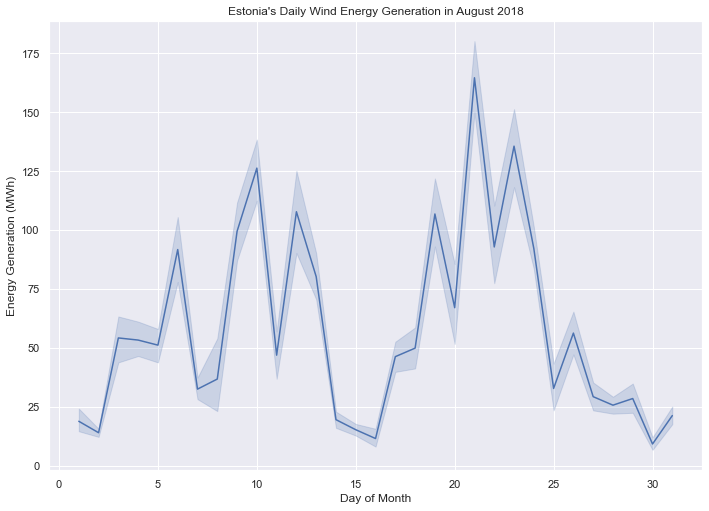

In [250]:
# plot to justify ffill instead of mean or zero fills
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import pyplot

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

date_range = wind_final['2018-8-01':'2018-8-31']
ax = sns.lineplot(ax=ax, data=date_range,x=date_range.index.day,y='EE')

ax.set(xlabel='Day of Month', ylabel='Energy Generation (MWh)',title='Estonia\'s Daily Wind Energy Generation in August 2018')
fig.savefig("estonia_wind_august2018.png", dpi=300)

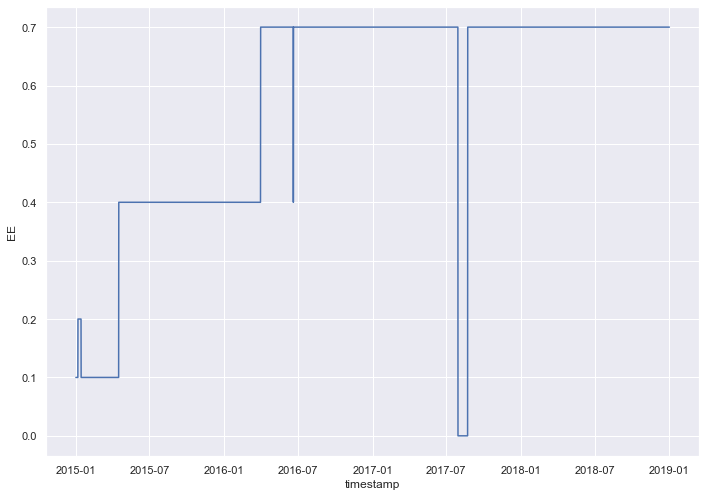

In [227]:
# Estonia has odd solar data
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=solar_final,x=solar_final.index,y='EE')

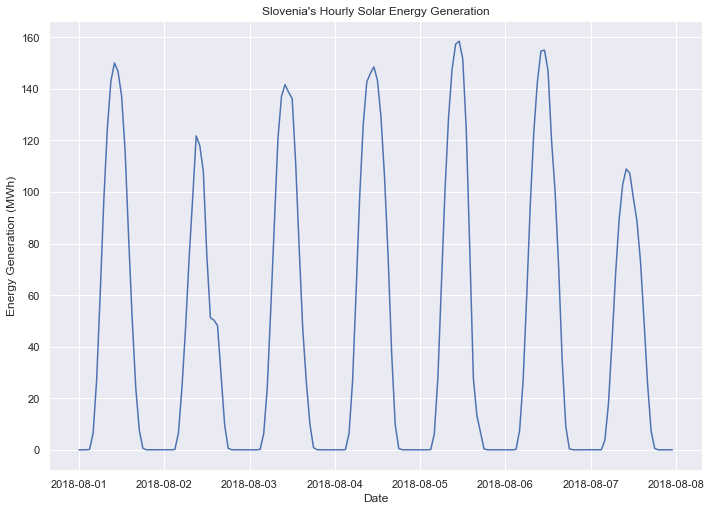

In [228]:
# plot to justify ffill instead of mean or zero fills
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import pyplot

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

date_range = solar_final['2018-8-01':'2018-8-7']
ax = sns.lineplot(ax=ax, data=date_range,x=date_range.index,y='SI')

ax.set(xlabel='Date', ylabel='Energy Generation (MWh)',title='Slovenia\'s Hourly Solar Energy Generation')
fig.savefig("slovenia_solar_august2018.png", dpi=300)

In [244]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

g = wind_final.isnull()#.sum(axis=1)
g.groupby(g.index.year).sum()

# ffill because the data looks seasonal and the missing values are evenly spread across the years, 
# where one day a month may have half a day of missing values

region,AT,BG,CH,CZ,DE,DK,EE,ES,FI,FR,GR,HU,LT,LV,PL,PT,RO,SE,SI
timestamp,,,,,,,,,,,,,,,,,,,
2015,0.0,0.0,96.0,0.0,0.0,0.0,27.0,6.0,4.0,0.0,5.0,446.0,214.0,0.0,0.0,0.0,109.0,95.0,0.0
2016,0.0,0.0,48.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,5.0,498.0,532.0,20.0,0.0,0.0,0.0,0.0,0.0
2017,0.0,0.0,23.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,5.0,469.0,13.0,17.0,0.0,0.0,0.0,0.0,0.0
2018,0.0,0.0,1.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,159.0,22.0,3.0,0.0,0.0,5.0,0.0,0.0


In [252]:
wind_filled = wind_final.fillna(method='ffill').fillna(method='bfill')
solar_filled = solar_final.fillna(method='ffill').fillna(method='bfill')

Save to file

In [253]:
wind_filled.to_csv('wind_generation.csv', float_format='%.1f',date_format='%Y-%m-%dT%H:%M:%SZ')
solar_filled.to_csv('solar_generation.csv', float_format='%.1f',date_format='%Y-%m-%dT%H:%M:%SZ')

# Results

In [6]:
import pandas as pd 

solar = pd.read_csv('solar_generation.csv')
wind = pd.read_csv('wind_generation.csv')

In [7]:
solar.shape

(35064, 20)

In [8]:
wind.shape

(35064, 20)

In [9]:
solar.columns

Index(['timestamp', 'AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FR',
       'GR', 'LT', 'NL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB'],
      dtype='object')

In [10]:
wind.columns

Index(['timestamp', 'AT', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GR', 'HU', 'LT', 'LV', 'PL', 'PT', 'RO', 'SE', 'SI'],
      dtype='object')

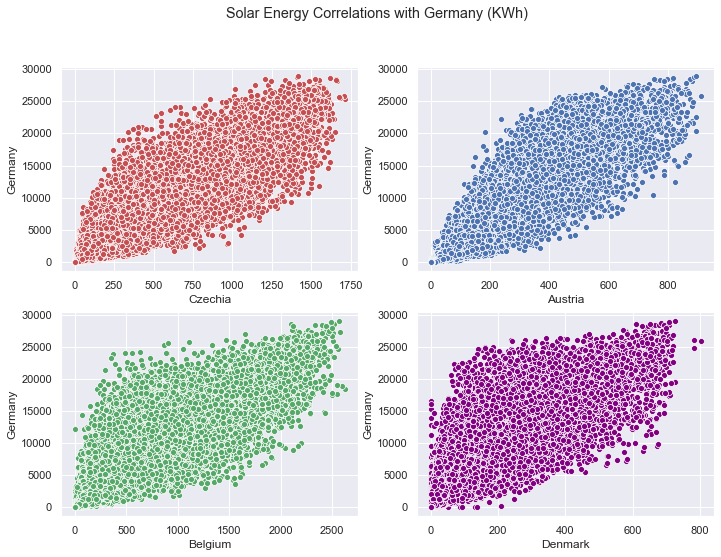

In [11]:
# solar is mostly geographic

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import pyplot
# Germany
a4_dims = (11.7, 8.27)
fig, ((ax1, ax2), (ax3, ax4))= pyplot.subplots(nrows=2, ncols=2, figsize=a4_dims)
sns.scatterplot(ax=ax1, x="CZ", y="DE", data=solar, color="r")
sns.scatterplot(ax=ax2, x="AT", y="DE", data=solar, color="b")
sns.scatterplot(ax=ax3, x="BE", y="DE", data=solar, color="g")
sns.scatterplot(ax=ax4, x="DK", y="DE", data=solar, color="purple")

pyplot.suptitle('Solar Energy Correlations with Germany (KWh)')
ax1.set(xlabel='Czechia', ylabel='Germany')
ax2.set(xlabel='Austria', ylabel='Germany')
ax3.set(xlabel='Belgium', ylabel='Germany')
ax4.set(xlabel='Denmark', ylabel='Germany')

fig.savefig("solar_germany_correlations.png", dpi=300)

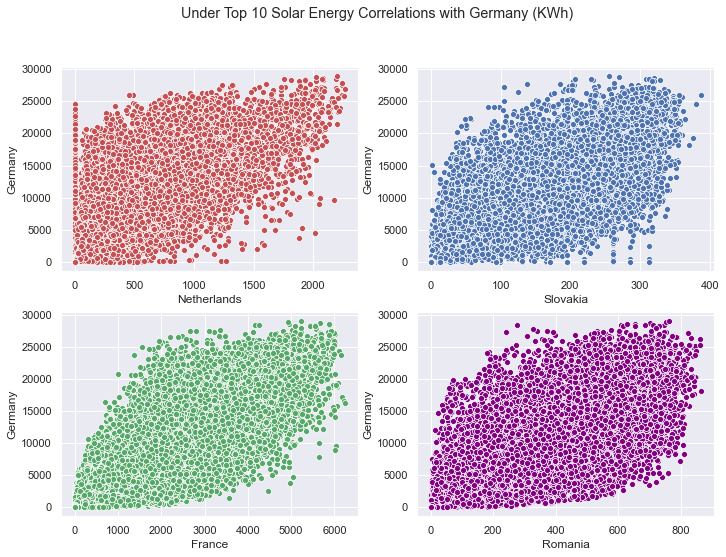

In [12]:
# Germany with other neighboring countries

a4_dims = (11.7, 8.27)
fig, ((ax1, ax2), (ax3, ax4))= pyplot.subplots(nrows=2, ncols=2, figsize=a4_dims)
sns.scatterplot(ax=ax1, x="NL", y="DE", data=solar, color="r")
sns.scatterplot(ax=ax2, x="SK", y="DE", data=solar, color="b")
sns.scatterplot(ax=ax3, x="FR", y="DE", data=solar, color="g")
sns.scatterplot(ax=ax4, x="RO", y="DE", data=solar, color="purple")

pyplot.suptitle('Under Top 10 Solar Energy Correlations with Germany (KWh)')
ax1.set(xlabel='Netherlands', ylabel='Germany')
ax2.set(xlabel='Slovakia', ylabel='Germany')
ax3.set(xlabel='France', ylabel='Germany')
ax4.set(xlabel='Romania', ylabel='Germany')

fig.savefig("solar_germany_non_correlations.png", dpi=300)

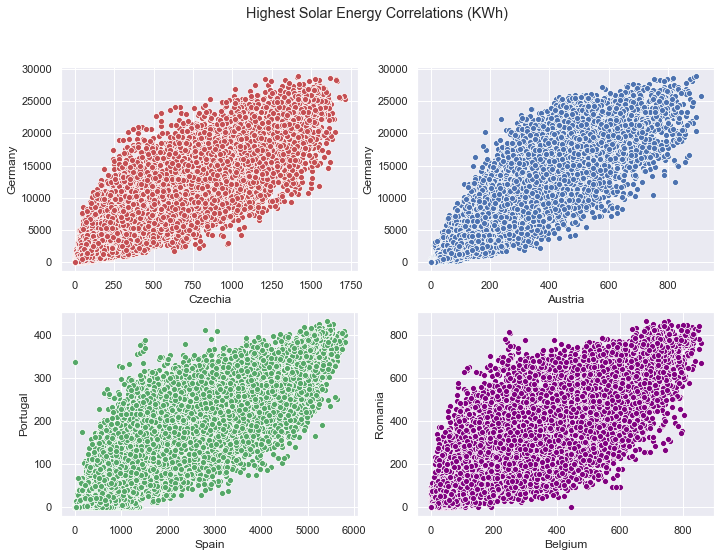

In [13]:
# Top solar pairs

a4_dims = (11.7, 8.27)
fig, ((ax1, ax2), (ax3, ax4))= pyplot.subplots(nrows=2, ncols=2, figsize=a4_dims)
sns.scatterplot(ax=ax1, x="CZ", y="DE", data=solar, color="r")
sns.scatterplot(ax=ax2, x="AT", y="DE", data=solar, color="b")
sns.scatterplot(ax=ax3, x="ES", y="PT", data=solar, color="g")
sns.scatterplot(ax=ax4, x="BG", y="RO", data=solar, color="purple")

pyplot.suptitle('Highest Solar Energy Correlations (KWh)')
ax1.set(xlabel='Czechia', ylabel='Germany')
ax2.set(xlabel='Austria', ylabel='Germany')
ax3.set(xlabel='Spain', ylabel='Portugal')
ax4.set(xlabel='Belgium', ylabel='Romania')

fig.savefig("solar_highest_correlations.png", dpi=300)

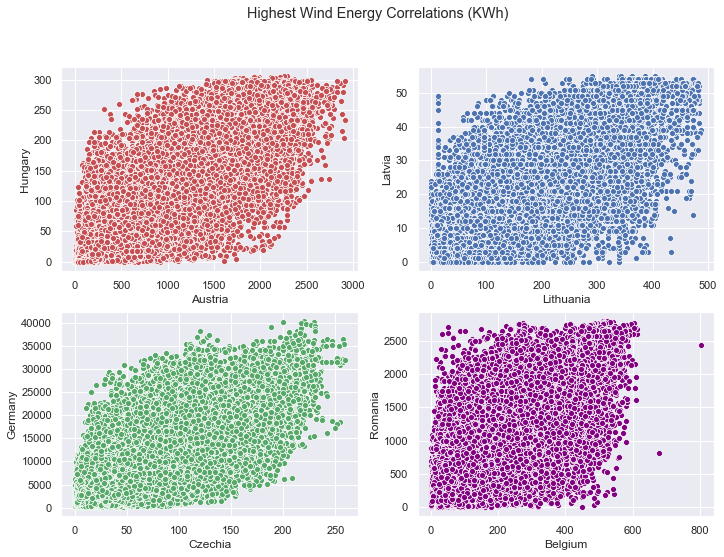

In [14]:
# wind is mostly geographic too
# the scales vary greately from country to country, even amongst correlated countries

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import pyplot
# Czechia and Germany
a4_dims = (11.7, 8.27)
fig, ((ax1, ax2), (ax3, ax4))= pyplot.subplots(nrows=2, ncols=2, figsize=a4_dims)
sns.scatterplot(ax=ax1, x="AT", y="HU", data=wind, color="r")
sns.scatterplot(ax=ax2, x="LT", y="LV", data=wind, color="b")
sns.scatterplot(ax=ax3, x="CZ", y="DE", data=wind, color="g")
sns.scatterplot(ax=ax4, x="BG", y="RO", data=wind, color="purple")

pyplot.suptitle('Highest Wind Energy Correlations (KWh)')
ax1.set(xlabel='Austria', ylabel='Hungary')
ax2.set(xlabel='Lithuania', ylabel='Latvia')
ax3.set(xlabel='Czechia', ylabel='Germany')
ax4.set(xlabel='Belgium', ylabel='Romania')

fig.savefig("wind_highest_correlations.png", dpi=300)